In [ ]:
!pip install gymnasium[continuous-control]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 5.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import gymnasium as gym

import matplotlib.pyplot as plt

import imageio
from IPython.display import HTML
from base64 import b64encode
import numpy as np

In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [ ]:
obs, info = env.reset()

In [ ]:
print(obs) # [x, theta, x_dot, theta_dot]

[-0.00964691 -0.0070897   0.04574091 -0.02072696]


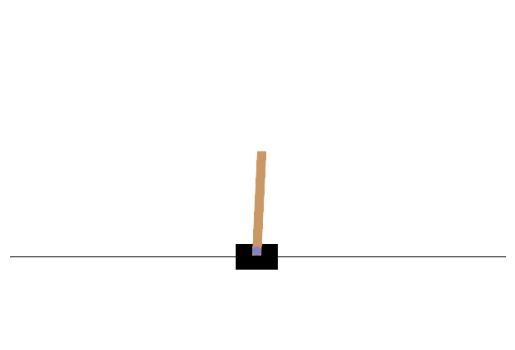

In [ ]:
img = env.render()
plt.imshow(img)
plt.axis('off')
plt.show()

# Implementing the DQN Algorithm

[paper](https://arxiv.org/abs/1312.5602)

## Defining the replay buffer

In [ ]:
class ReplayBuffer:
  def __init__(self, d_state, max_size):
    self.d_state = d_state
    self.max_size = max_size

    self.states = torch.zeros((max_size, d_state))
    self.actions = torch.zeros(max_size, dtype=torch.long)
    self.rewards = torch.zeros(max_size)
    self.next_states = torch.zeros((max_size, d_state))
    self.terminal = torch.zeros(max_size, dtype=torch.bool)

    self.i = 0
    self.n = 0

  def add_data(self, state, action, reward, next_state, terminal):
    # wraps around if we hit max_size
    if self.i == self.max_size:
      self.i = 0

    self.states[self.i] = state
    self.actions[self.i] = action
    self.rewards[self.i] = reward
    self.next_states[self.i] = next_state
    self.terminal[self.i] = terminal

    self.i += 1
    if self.n < self.max_size:
      self.n += 1

  def sample_batch(self, batch_size):
    # Sample batch_size random integers from 0 to self.n-1
    batch_indices = torch.randint(self.n, (batch_size,))

    # index into self. states, actions, rewards, and next_states with the random indices
    states = self.states[batch_indices]
    actions = self.actions[batch_indices]
    rewards = self.rewards[batch_indices]
    next_states = self.next_states[batch_indices]
    terminals = self.terminal[batch_indices]

    return states, actions, rewards, next_states, terminals


## Defining the Q functions

In [ ]:
class Qfunction(nn.Module):
  def __init__(self, d_state, n_act, d_hidden_1, d_hidden_2, activation=nn.ReLU):
    super().__init__()
    self.d_state = d_state
    self.n_act = n_act
    self.model = nn.Sequential(
        nn.Linear(d_state, d_hidden_1),
        activation(),
        nn.Linear(d_hidden_1, d_hidden_2),
        activation(),
        nn.Linear(d_hidden_2, n_act),
    )

  def forward(self, state):
    return self.model(state) # returns a q value for every action

In [ ]:
def visualize_cartpole(policy_fn, n_frames=500, name="bc_policy", start_state=None, obs_thresh=100):
  env = gym.make("CartPole-v1", render_mode="rgb_array")
  obs, _ = env.reset()
  if start_state is not None:
    env.state[:] = start_state
  frames = []
  for t in range(n_frames):
    frames.append(env.render().copy())
    act = policy_fn(obs, t)
    obs, rew, done, trunc, info = env.step(act)
    if np.linalg.norm(obs) > obs_thresh:
      print("WARNING: policy made the cartpole go too fast")
      break

  vid_name = f"{name}.mp4"
  imageio.mimsave(vid_name, frames, fps=50)

  mp4 = open(vid_name,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return data_url

def make_model_policy_fn(q_function):
  def model_policy_fn(state, t):
    state_t = torch.from_numpy(state)
    q_values = q_function(state_t)
    action = torch.argmax(q_values).numpy()
    return action
  return model_policy_fn


# DQN Algorithm

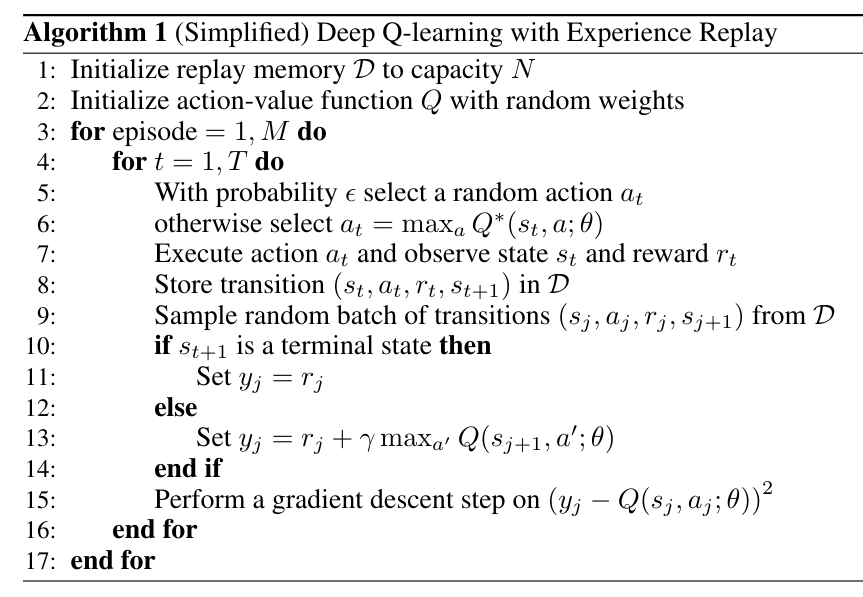

## Implementing DQN

In [ ]:
d_state = 4
n_act = 2
max_size = 100000

seed_steps = 10000

episodes = 5000
T = 500
epsilon_min = 0.1
epsilon_anneal_steps = 10000
lr = 1e-4
momentum = 0.0
batch_size = 32
gamma = 0.99
train_every = 4
n_q_updates = 1
print_every = 250

replay_buffer = ReplayBuffer(d_state, max_size) # Algo line 1
q_function = Qfunction(d_state, n_act, 128, 128) # Algo line 2

optim = torch.optim.Adam(q_function.parameters(), lr=lr)

In [ ]:
def update_q_function(q_function, replay_buffer):
  for i in range(n_q_updates):
    batch = replay_buffer.sample_batch(batch_size)
    state, action, reward, next_state, terminal = batch
    # TODO: implement this
    q_values = q_function(next_state).detach()
    nxt_reward = q_values.max(dim = 1).values
    y = reward + gamma * nxt_reward * terminal.logical_not()

    all_q_values = q_function(state)
    q_action = torch.gather(all_q_values, 1, action.unsqueeze(1)).squeeze()

    loss_fn = F.mse_loss
    loss = loss_fn(q_action, y)

    optim.zero_grad()
    loss.backward()
    optim.step()

In [ ]:
state, info = env.reset()
for i in range(seed_steps):
  action = env.action_space.sample()
  next_state, reward, done, trunc, info = env.step(action)

  state_t = torch.from_numpy(state.copy())
  action_t = torch.tensor(action)
  next_state_t = torch.from_numpy(next_state.copy())
  replay_buffer.add_data(state_t, action_t, reward, next_state_t, done)

  if done:
    state, info = env.reset()


In [ ]:
total_steps = 0
episode_rewards = []
for episode in range(episodes):
  state, info = env.reset()
  ep_reward = 0.0
  for t in range(T):
    if total_steps < epsilon_anneal_steps:
      epsilon = (epsilon_min - 1) / epsilon_anneal_steps * total_steps + 1
    else:
      epsilon = epsilon_min
    if torch.rand(()) < epsilon: # Algo line 5
      action = env.action_space.sample()
      action_t = torch.tensor(action)
    else:
      state_t = torch.from_numpy(state.copy())
      # TODO: implement q policy here
      q = q_function(state_t)
      action_t = torch.argmax(q)
      action = action_t.numpy()

    next_state, reward, done, trunc, info = env.step(action) # Algo line 7
    ep_reward += reward

    next_state_t = torch.from_numpy(next_state.copy())
    replay_buffer.add_data(state_t, action_t, reward, next_state_t, done) # Algo line 8

    if total_steps % train_every == 0:
      q_loss = update_q_function(q_function, replay_buffer)
    total_steps += 1

    if done:
      state, info = env.reset()
      break
    else:
      state = next_state
    episode_rewards.append(ep_reward)
  if episode % print_every == 0:
    print("episode", episode, "total_steps", total_steps)
    print("avg ep reward:", torch.mean(torch.tensor(episode_rewards[-print_every:])).item())
    print("q_loss", q_loss, "epsilon", epsilon)
    print()

episode 0 total_steps 17
avg ep reward: 8.5
q_loss None epsilon 0.99856

episode 250 total_steps 18970
avg ep reward: 98.30799865722656
q_loss None epsilon 0.1



In [ ]:
policy_fn = make_model_policy_fn(q_function)
data_url = visualize_cartpole(policy_fn)
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

/usr/local/lib/python3.10/dist-packages/gymnasium/envs/classic_control/cartpole.py:180: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


## Other things you can try:
* adding a target network
* double min Q values